<a href="https://colab.research.google.com/github/aghosh92/gpax/blob/main/examples/contrib/gpax_dkl_notebookIII_molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, we explore how Deep Kernel Learning (DKL) can be applied to molecular dataset, or can be built as an active experiment where the features (molecular structures) are available all at the same time, and the targets are becoming available sequentially. It  provides a way to guide 'experimental' discovery, and also forms particularly well organized latent spaces.

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh (SMIILES to SELFIES part), research.aghosh@gmail.com
- The GPax is by Maxim Ziatdinov, https://github.com/ziatdinovmax/gpax
- The DKL is adapted from the notebooks from Mani Valleti, svalleti@vols.utk.edu
- Workflow built by Sergei V. Kalinin
- DKL for subsets of QM9 dataset adapted by Ayana Ghosh

In [ ]:
# @title Install packages
!pip install wget
!pip install rdkit-pypi
!pip install selfies --upgrade
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai  # we will use the AtomAI VAE

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e42316a62f9377fdedc0d459b223c76fbcb585d645b6a02f00cf434d9d3b2f72
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 27.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
# @title Import libraries
import wget
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import warnings

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

import torch
import torch.nn as nn
tt = torch.tensor
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize
from scipy.spatial import distance

import selfies as sf
import gpax
import atomai as aoi

import jax.numpy as jnp
gpax.utils.enable_x64()

In [ ]:
# @title Utility functions for extracting molecules from latent space
def find_nearest_neighbors(reference_idx, embedding, num_neighbors=9):
    """Find the indices of the nearest neighbors to a reference point."""
    reference_point = embedding[reference_idx]
    distances = distance.cdist([reference_point],
                               embedding, 'euclidean').flatten()
    # Exclude the reference point itself
    nearest_indices = np.argsort(distances)[1:num_neighbors+1]
    # Ignore userwarnings
    warnings.filterwarnings("ignore", category=UserWarning)
    return nearest_indices

def find_indices(original, search):
    indices = []
    for row in search:
        # Find the index of the row in the original array
        index = np.where((original == row).all(axis=1))[0]
        if index.size > 0:
            indices.append(index[0])
        else:
            indices.append(-1)  # -1 indicates not found
    return np.array(indices)

def are_points_separated(point, other_points, min_distance):
    """Check if 'point' is at least 'min_distance' away
       from all points in 'other_points'."""
    return np.all(np.linalg.norm(other_points - point, axis=1) >= min_distance)

## Read in dataset (One of the subsets from QM9 containing 12,000 randomly selected molecules)

## We have generated the dataset by reading the SMILE representations, computing a few features (such as molecular weight, molar log P etc.) using RDKit and appended the DFT-computed endpoint properties (e.g., enthalpy, dipole moments etc.) as noted in the QM9 dataset.

In [ ]:
git_link = "https://github.com/aghosh92/DKLActiveLearnMol/blob/main/datasets/dataset4_12k.csv?raw=true"
df = pd.read_csv(git_link, index_col=0)
df

,Unnamed: 0,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,...,stereocent,dipole_moment,enthalpy,internal_energy,internal_energy_zero,free_energy,homo,lumo,gap,zero_point_vib_energy
80704,80704,OCC(C#C)C#CC#C,-0.13530,20.23,118.041865,1,1,"(44,)",0.104838,-0.394070,...,1,1.0110,-383.379422,-383.380366,-383.390139,-383.425247,-0.2487,-0.0227,0.2260,0.109023
65243,65243,OC1C2NC1(C#C)C2O,-1.93440,52.49,125.047678,3,3,"(48,)",0.135711,-0.388302,...,2,2.9389,-437.764349,-437.765293,-437.773455,-437.805879,-0.2457,0.0183,0.2640,0.123328
127044,127044,C1C2C3CC(CCO3)N12,0.23180,12.24,125.084064,0,2,"(50,)",0.075724,-0.376416,...,4,1.2046,-403.111686,-403.112630,-403.119162,-403.149575,-0.2233,0.0819,0.3052,0.175386
78132,78132,CC1=CC2CC(O2)C1O,0.46470,29.46,126.068080,1,2,"(50,)",0.101096,-0.386045,...,3,2.0914,-423.006427,-423.007371,-423.015176,-423.047111,-0.2388,0.0018,0.2405,0.160473
90425,90425,CC1CC1(O)CCC=O,0.73640,37.30,128.083730,1,2,"(52,)",0.119600,-0.389588,...,2,2.1074,-424.213274,-424.214219,-424.224729,-424.261135,-0.2481,-0.0208,0.2273,0.178994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7888,7888,CC1CC(C)=C(C1)C#N,2.25638,23.79,121.089149,0,1,"(48,)",0.094610,-0.192796,...,1,4.6698,-366.056947,-366.057891,-366.067193,-366.101254,-0.2477,-0.0319,0.2158,0.171019
112961,112961,CCC1OC2COCC12,0.81020,18.46,128.083730,0,2,"(52,)",0.088686,-0.378248,...,3,1.9884,-424.211657,-424.212601,-424.220882,-424.253909,-0.2461,0.0852,0.3313,0.184007
106544,106544,OC1C2C3CN=C1N23,-1.17420,35.60,110.048013,1,3,"(42,)",0.133409,-0.382929,...,4,2.1845,-378.611347,-378.612291,-378.617991,-378.647519,-0.2537,-0.0527,0.2011,0.108810
22357,22357,CC#CCC1OC2CC12,1.18710,9.23,122.073165,0,1,"(48,)",0.074149,-0.373200,...,3,1.8530,-385.812115,-385.813060,-385.822342,-385.859017,-0.2353,0.0546,0.2899,0.157721


## Convert smiles to selfies

Note on SMILEs: Simplified Molecular
Input Line Entry System (SMILES) which is string representaiton of molecules. although widely employed SMILES may lead to syntactic and semantic invalidities
in string-based molecular representations which may be difficult to deal with duing ML trainings.

Note on SELFIES: SELFreferencIng Embedded Strings which is formulated
through a small Chomsky type-2, context-free grammar that is augmented with self-referencing functions to handle the generation of branches and rings. These are typically robust to both syntactic and semantic errors.

In [ ]:
selfies_dataset = []
error_smiles = []

# Assuming 'smiles' is the column in df containing SMILES strings
# Replace 'smiles' with the actual column name if it's different
for i, row in df.iterrows():
    try:
        local_sf = sf.encoder(row['smiles'])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        # Store the SMILES string that caused the error
        error_smiles.append(row['smiles'])
        continue  # Skip to the next iteration

## Generate one-hot vectors for molecules

Here we convert SELFIES to one-hot enoding such that each molecules present in the dataset can be represented with corresponding one-hot vectors of same sizes.

In [ ]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
#[nop] is a special padding symbol
alphabet.add("[nop]")
alphabet = list(sorted(alphabet))

length_list = []
for s in selfies_dataset:
  length = sf.len_selfies(s)
  length_list.append(length)
length_list.sort()
pad_to_len = length_list[-1]

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i],
                                          vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)

(12000, 567)


## Choose target properties of interest

(Can be a pre-computed property such as dipole moment as can be found from QM9 dataset or other molecularfeatures)

In [ ]:
#Different targets
targets1 = df['ringct'].values
targets2 = df['mole_logp'].values
targets3 = df['mol_wt'].values
targets4 = df['dipole_moment'].values

## Train DKL model

For illustration purpose, we show the training on 1,000 molecules since training on a higher number of molecules may take longer & more computing resources.

Here, the idea is to have the one-hot vectors in the X dimension and the y dimension represents a target such as number of ring counts to train the model.

In [ ]:
X1 = np.copy(X)
X1 = X1[:1000]
targets1 = targets1[:1000]

#Train the DKL model
rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()
dkl_1 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_1.fit(rng_key_1, X1, targets1)

100%|██████████| 1000/1000 [08:13<00:00,  2.03it/s, init loss: 41045.4279, avg. loss [951-1000]: 36806.3720]



Inferred GP kernel parameters
k_length         [1.4378 1.226 ]
k_scale          5.5997
noise            0.0154


## Predict using the trained DKL model

Once the model is trained, we use the model to generate embedding of the X (molecular representaitons via hot vectors) to predict the the target property for all molecules embedded in the space. This helps us to understand whether the molecules embedded with different features show any correlation with the predicted targets, thus lead to understanding the organization of the latent spaces with respect to the targets.

In [ ]:
batch_size_reconstruct = 250

embeded_1 = dkl_1.embed(X1)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1,
                                                 X1, batch_size=batch_size_reconstruct)
pred_std1 = jnp.sqrt(pred_var1)

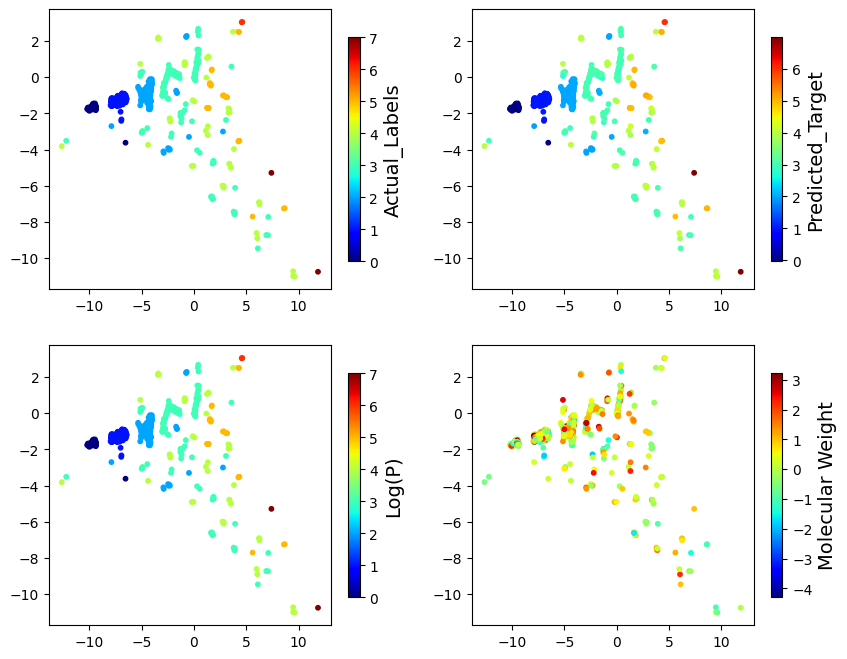

In [ ]:
# @title visualize latent space
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = targets1, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = pred_mean1, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = targets1,
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = targets2[:1000], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Molecular Weight", fontsize=14)
cbar.ax.tick_params(labelsize=10)

## Active learning

## We perform the active learning here in order to explore if we can recontruct the behavior of the molecular property over the full chemical space of interest when we start from a few selected points.

## We run the DKL within an active learning settings -- meaning that all the features are available (equivalently our search space is defined), whereas targets are becoming available sequentially, as would be the case for (expensive) experiments.

In [ ]:
X1 = np.copy(X)
X1 = X1[:1000]
#target
targets1 = - df['internal_energy'].values
targets1 = targets1[:1000]

For illustration purpose, we show the training on 1,000 molecules with 30 exploration steps since training on a higher number of molecules may take longer & more computing resources.

## Set up active learning parameters

In [ ]:
#Active learning setup parameters
init_num = 50
exp_step = 30
batch_size_learn = 50 #make it 100 if start with 100 seed
batch_size_reconstruct = 250

In [ ]:
np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = init_num, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(X))
indices_train_1 = indices_total_1[idx1]
y1_train = targets1[idx1]
indices_unmeasured_1 = np.delete(indices_total_1, idx1)

## Active learning loop

In [ ]:
exp_mean1, exp_std1 = [], []
dkl_mean1, dkl_std1 = [], []
embed_traj1 = []
traj_mean1, traj_std1 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key11, rng_key_predict11 = gpax.utils.get_keys()
    dkl_BO_1 = gpax.viDKL(s2*s3, 2, 'RBF')
    dkl_BO_1.fit(rng_key11, X1_train, y1_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_1.predict_in_batches(#make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean1.append(y_mean[id_next])
    exp_std1.append(y_std[id_next])

    x_next = X1_unmeasured[id_next]
    ind_next = indices_unmeasured_1[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean1.append(pred_mean1[ind_next])
    dkl_std1.append(pred_std1[ind_next])

    # Perform evaluation
    y_measured = targets1[ind_next]

    # Update training arrays
    X1_train = np.append(X1_train, x_next[None], axis=0)
    y1_train = np.append(y1_train, y_measured)
    X1_unmeasured = np.delete(X1_unmeasured, id_next, axis=0)
    indices_unmeasured_1 = np.delete(indices_unmeasured_1, id_next)

    embed_traj = dkl_BO_1.embed(X1_train)
    traj_m, traj_s = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_train, batch_size=batch_size_learn)

    embed_traj1.append(embed_traj)
    traj_mean1.append(traj_m)
    traj_std1.append(traj_s)


Step 1


100%|██████████| 1000/1000 [00:05<00:00, 174.54it/s, init loss: 1217502.9843, avg. loss [951-1000]: 55683.7926]



Inferred GP kernel parameters
k_length         [1.4127 1.0083]
k_scale          6.239400000000001
noise            2.3738

Step 2


100%|██████████| 1000/1000 [00:10<00:00, 98.36it/s, init loss: 1223489.3096, avg. loss [951-1000]: 55911.4626]



Inferred GP kernel parameters
k_length         [1.4033 0.9796]
k_scale          6.1947
noise            2.3349

Step 3


100%|██████████| 1000/1000 [00:07<00:00, 131.63it/s, init loss: 1228800.0542, avg. loss [951-1000]: 55935.6887]



Inferred GP kernel parameters
k_length         [1.4097 0.957 ]
k_scale          6.2005
noise            2.3232

Step 4


100%|██████████| 1000/1000 [00:06<00:00, 149.92it/s, init loss: 1267130.0671, avg. loss [951-1000]: 56063.9110]



Inferred GP kernel parameters
k_length         [1.4104 0.9634]
k_scale          6.179600000000001
noise            2.2906

Step 5


100%|██████████| 1000/1000 [00:07<00:00, 128.39it/s, init loss: 1268582.9535, avg. loss [951-1000]: 55993.3360]



Inferred GP kernel parameters
k_length         [1.4132 0.952 ]
k_scale          6.186100000000001
noise            2.2978

Step 6


100%|██████████| 1000/1000 [00:09<00:00, 110.93it/s, init loss: 1269343.7497, avg. loss [951-1000]: 56050.1418]



Inferred GP kernel parameters
k_length         [1.4127 0.9692]
k_scale          6.1679
noise            2.3072

Step 7


100%|██████████| 1000/1000 [00:06<00:00, 150.06it/s, init loss: 1300957.0410, avg. loss [951-1000]: 56162.8655]



Inferred GP kernel parameters
k_length         [1.4249 0.9707]
k_scale          6.0999
noise            2.2956000000000003

Step 8


100%|██████████| 1000/1000 [00:06<00:00, 143.27it/s, init loss: 1302948.4615, avg. loss [951-1000]: 56218.9840]



Inferred GP kernel parameters
k_length         [1.4335 0.9817]
k_scale          6.1047
noise            2.3076000000000003

Step 9


100%|██████████| 1000/1000 [00:07<00:00, 128.66it/s, init loss: 1303818.1387, avg. loss [951-1000]: 56322.5184]



Inferred GP kernel parameters
k_length         [1.4048 0.9705]
k_scale          6.0879
noise            2.3168

Step 10


100%|██████████| 1000/1000 [00:08<00:00, 121.91it/s, init loss: 1306985.7140, avg. loss [951-1000]: 56284.1712]



Inferred GP kernel parameters
k_length         [1.4262 0.9671]
k_scale          6.087000000000001
noise            2.3161

Step 11


100%|██████████| 1000/1000 [00:08<00:00, 123.82it/s, init loss: 1307765.3687, avg. loss [951-1000]: 56304.5876]



Inferred GP kernel parameters
k_length         [1.4247 0.9647]
k_scale          6.0924000000000005
noise            2.3142

Step 12


100%|██████████| 1000/1000 [00:08<00:00, 119.03it/s, init loss: 1327535.9093, avg. loss [951-1000]: 56444.5376]



Inferred GP kernel parameters
k_length         [1.4215 0.9652]
k_scale          6.0353
noise            2.3318000000000003

Step 13


100%|██████████| 1000/1000 [00:07<00:00, 127.28it/s, init loss: 1332147.7016, avg. loss [951-1000]: 56449.8337]



Inferred GP kernel parameters
k_length         [1.4221 0.9701]
k_scale          6.0208
noise            2.3293

Step 14


100%|██████████| 1000/1000 [00:06<00:00, 148.49it/s, init loss: 1332330.2636, avg. loss [951-1000]: 56380.6733]



Inferred GP kernel parameters
k_length         [1.4263 0.981 ]
k_scale          6.027900000000001
noise            2.3600000000000003

Step 15


100%|██████████| 1000/1000 [00:06<00:00, 156.55it/s, init loss: 1349568.3276, avg. loss [951-1000]: 56748.9993]



Inferred GP kernel parameters
k_length         [1.4344 0.9549]
k_scale          5.9747
noise            2.3434

Step 16


100%|██████████| 1000/1000 [00:05<00:00, 168.56it/s, init loss: 1349648.6853, avg. loss [951-1000]: 56544.9519]



Inferred GP kernel parameters
k_length         [1.4325 0.9799]
k_scale          5.9927
noise            2.3587000000000002

Step 17


100%|██████████| 1000/1000 [00:06<00:00, 153.85it/s, init loss: 1364066.2112, avg. loss [951-1000]: 56768.3311]



Inferred GP kernel parameters
k_length         [1.4334 0.9278]
k_scale          5.9726
noise            2.3605

Step 18


100%|██████████| 1000/1000 [00:07<00:00, 128.80it/s, init loss: 1368109.4108, avg. loss [951-1000]: 56583.9442]



Inferred GP kernel parameters
k_length         [1.4287 0.9547]
k_scale          5.992100000000001
noise            2.3554

Step 19


100%|██████████| 1000/1000 [00:07<00:00, 127.77it/s, init loss: 1373265.4923, avg. loss [951-1000]: 56640.0052]



Inferred GP kernel parameters
k_length         [1.4155 0.9465]
k_scale          5.9798
noise            2.3214

Step 20


100%|██████████| 1000/1000 [00:08<00:00, 122.54it/s, init loss: 1398978.4377, avg. loss [951-1000]: 56804.9199]



Inferred GP kernel parameters
k_length         [1.4207 0.9445]
k_scale          5.934200000000001
noise            2.3396

Step 21


100%|██████████| 1000/1000 [00:08<00:00, 121.77it/s, init loss: 1400552.7996, avg. loss [951-1000]: 56788.9319]



Inferred GP kernel parameters
k_length         [1.4236 0.9639]
k_scale          5.9299
noise            2.3514

Step 22


100%|██████████| 1000/1000 [00:08<00:00, 122.14it/s, init loss: 1408117.1765, avg. loss [951-1000]: 56937.7792]



Inferred GP kernel parameters
k_length         [1.422  0.9448]
k_scale          5.896800000000001
noise            2.349

Step 23


100%|██████████| 1000/1000 [00:07<00:00, 130.34it/s, init loss: 1412069.0248, avg. loss [951-1000]: 56913.2492]



Inferred GP kernel parameters
k_length         [1.4184 0.9476]
k_scale          5.8861
noise            2.3717

Step 24


100%|██████████| 1000/1000 [00:06<00:00, 148.55it/s, init loss: 1414001.1423, avg. loss [951-1000]: 57000.0094]



Inferred GP kernel parameters
k_length         [1.4182 0.9623]
k_scale          5.87
noise            2.3941

Step 25


100%|██████████| 1000/1000 [00:07<00:00, 136.31it/s, init loss: 1416350.0690, avg. loss [951-1000]: 56913.0717]



Inferred GP kernel parameters
k_length         [1.4117 0.9563]
k_scale          5.8958
noise            2.3645

Step 26


100%|██████████| 1000/1000 [00:08<00:00, 114.91it/s, init loss: 1417215.1710, avg. loss [951-1000]: 56974.8013]



Inferred GP kernel parameters
k_length         [1.4173 0.9526]
k_scale          5.8908000000000005
noise            2.3541000000000003

Step 27


100%|██████████| 1000/1000 [00:08<00:00, 115.17it/s, init loss: 1423417.5746, avg. loss [951-1000]: 56984.9160]



Inferred GP kernel parameters
k_length         [1.4194 0.9618]
k_scale          5.8738
noise            2.3947000000000003

Step 28


100%|██████████| 1000/1000 [00:08<00:00, 123.89it/s, init loss: 1424037.5955, avg. loss [951-1000]: 57098.1507]



Inferred GP kernel parameters
k_length         [1.4372 0.9433]
k_scale          5.869400000000001
noise            2.4078

Step 29


100%|██████████| 1000/1000 [00:06<00:00, 148.02it/s, init loss: 1424946.7040, avg. loss [951-1000]: 56958.8950]



Inferred GP kernel parameters
k_length         [1.4184 0.9542]
k_scale          5.8823
noise            2.3850000000000002

Step 30


100%|██████████| 1000/1000 [00:06<00:00, 148.34it/s, init loss: 1426352.8805, avg. loss [951-1000]: 57028.9305]



Inferred GP kernel parameters
k_length         [1.4201 0.9682]
k_scale          5.8603000000000005
noise            2.3998


## Prediction

In [ ]:
#prediction
rng_key11, rng_key_predict11 = gpax.utils.get_keys()
dkl_BO_1 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_BO_1.fit(rng_key11, X1_train, y1_train)

predmean_train1, predstd_train1 = dkl_BO_1.predict_in_batches(rng_key_predict11,
                                                              X1_train, batch_size=batch_size_learn)
predmean_unmeas1, predstd_unmeas1 = dkl_BO_1.predict_in_batches(rng_key_predict11,
                                                                X1_unmeasured, batch_size=batch_size_reconstruct)
predmean11, predstd11 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1,
                                                    batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:07<00:00, 135.80it/s, init loss: 1426575.6054, avg. loss [951-1000]: 57015.0584]



Inferred GP kernel parameters
k_length         [1.4269 0.9447]
k_scale          5.8904000000000005
noise            2.3884000000000003


## Embeddings for training, unmeasured and all points

In [ ]:
embeded_train1 = dkl_BO_1.embed(X1_train)  # Measured points
embeded_unmeasured1 = dkl_BO_1.embed(X1_unmeasured)  # Unmeasured points
embeded11 = dkl_BO_1.embed(X1)   # All points

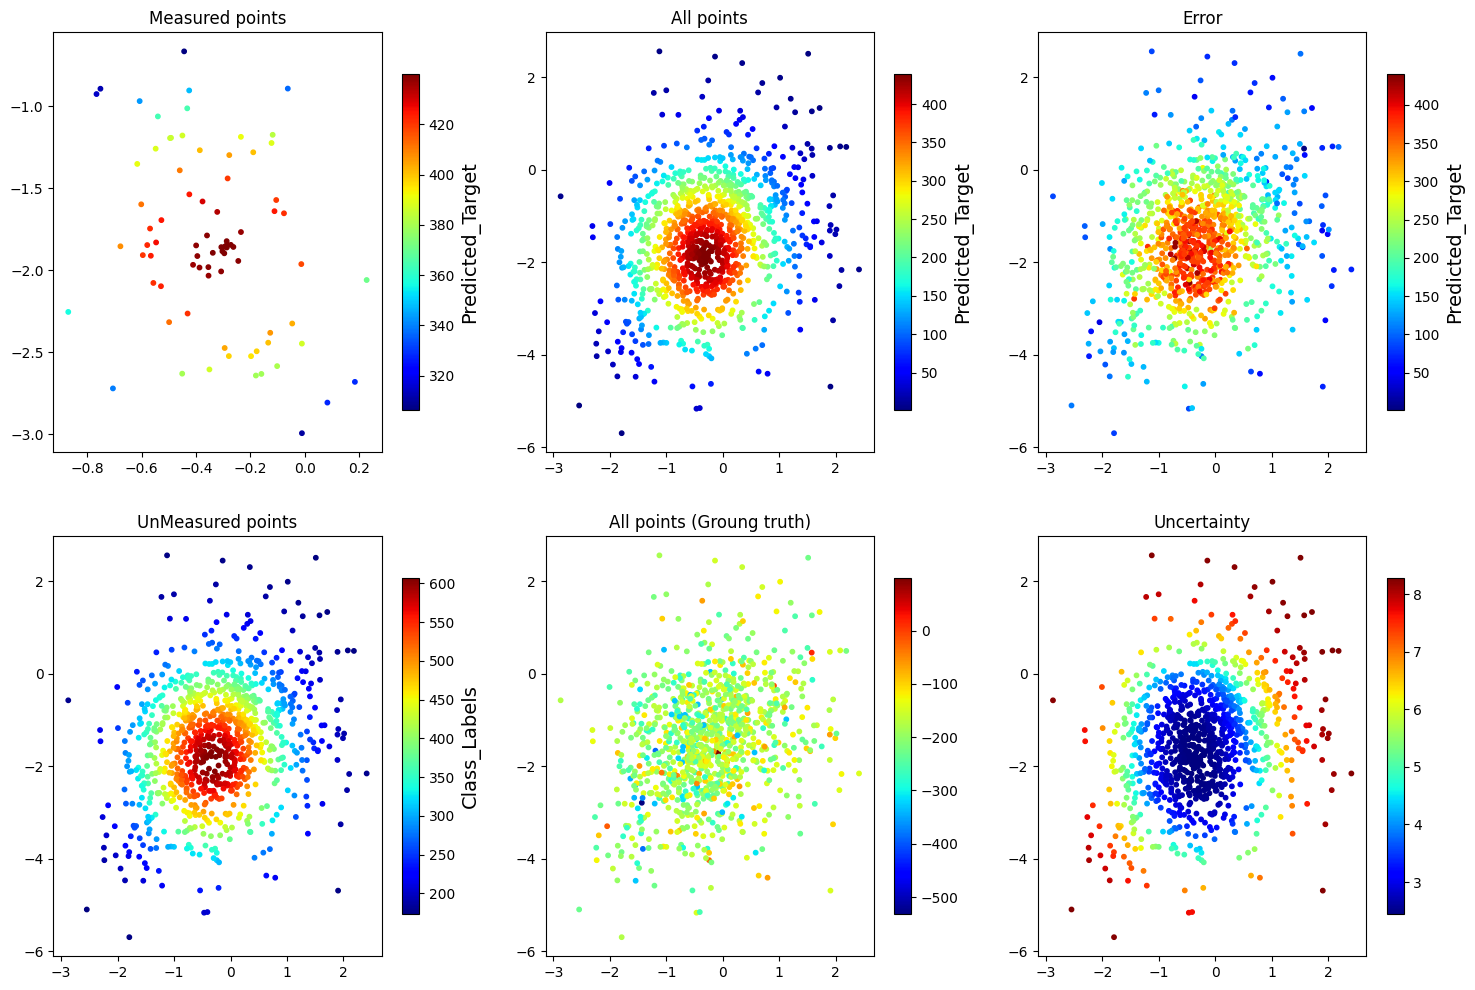

In [ ]:
# @title visualize latent space
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train1[:, 1], embeded_train1[:, 0], s=10, c = predmean_train1, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_unmeasured1[:, 1], embeded_unmeasured1[:, 0], s=10,
                c = predmean_unmeas1, cmap = 'jet')
ax[1,0].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = predmean11, cmap = 'jet')
ax[0,1].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = targets1, cmap = 'jet')
ax[1,1].set_title('All points (Groung truth)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = predmean11 - targets1, cmap = 'jet')
ax[0,2].set_title('Error')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
#cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = predstd11, cmap = 'jet')
ax[1,2].set_title('Uncertainty')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
#cbar.set_label("Wt", fontsize=14)
cbar.ax.tick_params(labelsize=10)